In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [5]:
directory="Stocks"
list(os.listdir(directory))

['a.us.txt',
 'aa.us.txt',
 'aaap.us.txt',
 'aaba.us.txt',
 'aac.us.txt',
 'aal.us.txt',
 'aamc.us.txt',
 'aame.us.txt',
 'aan.us.txt',
 'aaoi.us.txt',
 'aaon.us.txt',
 'aap.us.txt',
 'aapl.us.txt',
 'aat.us.txt',
 'aau.us.txt',
 'aav.us.txt',
 'aaww.us.txt',
 'aaxn.us.txt',
 'ab.us.txt',
 'abac.us.txt',
 'abax.us.txt',
 'abb.us.txt',
 'abbv.us.txt',
 'abc.us.txt',
 'abcb.us.txt',
 'abcd.us.txt',
 'abco.us.txt',
 'abdc.us.txt',
 'abe.us.txt',
 'abeo.us.txt',
 'abeow.us.txt',
 'abev.us.txt',
 'abg.us.txt',
 'abil.us.txt',
 'abio.us.txt',
 'ablx.us.txt',
 'abm.us.txt',
 'abmd.us.txt',
 'abr.us.txt',
 'abrn.us.txt',
 'abr_a.us.txt',
 'abr_b.us.txt',
 'abr_c.us.txt',
 'abt.us.txt',
 'abtx.us.txt',
 'abus.us.txt',
 'abx.us.txt',
 'aby.us.txt',
 'ac.us.txt',
 'acad.us.txt',
 'acbi.us.txt',
 'acc.us.txt',
 'acco.us.txt',
 'accp.us.txt',
 'acer.us.txt',
 'acerw.us.txt',
 'acet.us.txt',
 'acfc.us.txt',
 'acgl.us.txt',
 'acglo.us.txt',
 'acglp.us.txt',
 'ach.us.txt',
 'achc.us.txt',
 'achn.us.tx

In [6]:
file='hpq.us.txt'
df = pd.read_csv(os.path.join(directory, file))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12075 entries, 0 to 12074
Data columns (total 7 columns):
Date       12075 non-null object
Open       12075 non-null float64
High       12075 non-null float64
Low        12075 non-null float64
Close      12075 non-null float64
Volume     12075 non-null int64
OpenInt    12075 non-null int64
dtypes: float64(4), int64(2), object(1)
memory usage: 660.4+ KB


In [7]:
df['Average']=df.apply(lambda x: (x['Low']+x['High'])/2.0,axis=1)
df=df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Average
0,1970-01-02,0.30627,0.30627,0.30627,0.30627,2441124,0,0.306270
1,1970-01-05,0.30627,0.31768,0.30627,0.31385,6219848,0,0.311975
2,1970-01-06,0.31385,0.31385,0.30996,0.30996,4447522,0,0.311905
3,1970-01-07,0.31385,0.31385,0.31385,0.31385,1872638,0,0.313850
4,1970-01-08,0.31385,0.31768,0.31385,0.31385,4280330,0,0.315765


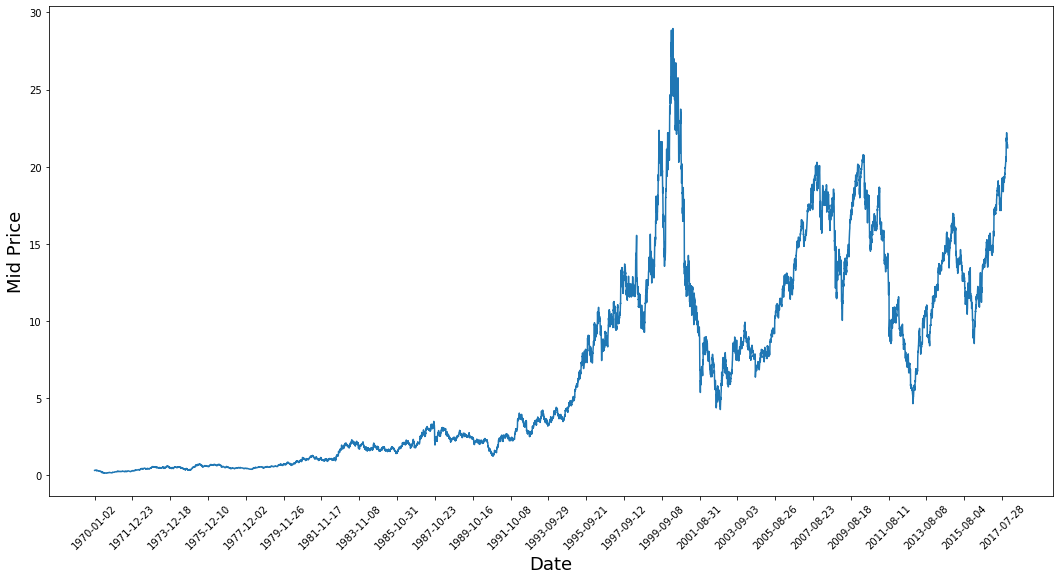

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),df['Average'])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Split the stock market data into 2 sets, where test set contains 5*chunk_size last elements.

In [9]:
chunk_size = 10

split_date = list(df["Date"][-(5*chunk_size+1):])[0]

training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Volume', 'OpenInt','Average'], 1)
test_set = test_set.drop(['Date','Volume','OpenInt','Average'], 1)

Divide the stock market data into sets containing each element together with 19 following elements and transform it in the form of relative increase and decrease percentage with respect to the previous value.

In [10]:
def prepare_data(data):
    LSTM_inputs = []
    for i in range(len(data)-chunk_size):
        temp_set = data[i:(i+chunk_size)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_inputs.append(temp_set)

    LSTM_outputs = (data['Close'][chunk_size:].values/data['Close'][:-chunk_size].values)-1

    LSTM_inputs = [np.array(LSTM_input) for LSTM_input in LSTM_inputs]
    LSTM_inputs = np.array(LSTM_inputs)
    
    return LSTM_inputs, LSTM_outputs

In [11]:
LSTM_training_inputs, LSTM_training_outputs = prepare_data(training_set)
LSTM_test_inputs, LSTM_test_outputs = prepare_data(test_set)

Pseudocode for LSTM:

def LSTMCELL(prev_ct, prev_ht, input):

    combine = prev_ht + input
    
    fl = forget_layer(combine) #decides what information we're going to throw away from the cell state -> using sigmoid function

    cl = candidate_layer(combine) #creates a vector of new candidate values, that could be added to the cell state -> using tanh fucntion
      
    il = input_layer(combine) #decides which vallues from tanh layer should be added to the cell state -> using sigmoid function
    
    Ct = prev_ct * fl + il #new cell state -> update cell state to the new values
    
    ol = output_layer(combine) #decides what parts of the cell state we're going to output
    
    ht = ol * tanh(Ct) #new hidden state -> only otput the parts we decided to
    
    return ht, Ct

ct = [0,0,0]

ht = [0,0,0]

for input in inputs:

    ct, ht = LSTMCELL(ct, ht, input)

In [12]:
def build_model(inputs, output_size, neurons, activ_func="linear", dropout=0.10, loss="mean_squared_error", optimizer="adam"):
    
    model = Sequential()
    
    model.add(LSTM(units = neurons, return_sequences = True, input_shape = (inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))

    model.add(LSTM(units = neurons, return_sequences = True))
    model.add(Dropout(dropout))

    model.add(LSTM(units = neurons, return_sequences = True))
    model.add(Dropout(dropout))

    model.add(LSTM(units = neurons))
    model.add(Dropout(dropout))

    model.add(Dense(units = output_size))
    model.add(Activation(activ_func))

    model.compile(optimizer = optimizer, loss = loss)
    
    return model

    
model = build_model(LSTM_training_inputs, output_size=1, neurons = 50)

model.fit(LSTM_training_inputs, LSTM_training_outputs, epochs = 5, batch_size = 32)

Epoch 1/5
12014/12014 [==============================] - 10s 815us/step - loss: 0.0015
Epoch 2/5
12014/12014 [==============================] - 8s 693us/step - loss: 6.8741e-04
Epoch 3/5
12014/12014 [==============================] - 8s 697us/step - loss: 6.3520e-04
Epoch 4/5
12014/12014 [==============================] - 8s 693us/step - loss: 6.2727e-04
Epoch 5/5
12014/12014 [==============================] - 9s 710us/step - loss: 6.0549e-04


The Mean Absolute Error is: 0.006678571181315221


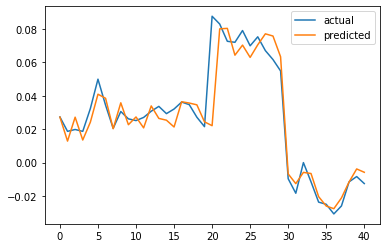

In [13]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
MAE = mean_absolute_error(LSTM_test_outputs, model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))